# Keyness analysis per Genre

In [1]:
# This reload library is just used for developing the notebook
# code and can be removed once this is stable.
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.topic_summary import ModelAnalyser, NurGenreMapper, ReviewExtractor

/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users

## Read datasets

In [3]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review_work_genre-impact_terms.tsv.gz'
raw_review_data = '../data/review-stats-clean.tsv.gz'
isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"

In [4]:
from impfic_core.map.map_genre import read_genre_file

# read review metadata
review_stats = pd.read_csv(raw_review_data, sep='\t', compression='gzip')

review_stats

,review_id,source,work_id,user_id,nur_genre,review_num_words,review_date,rating
0,impfic-review-100000,Hebban,impfic-work-18247,impfic-user-220787,Young_adult,158,2021-04-20 12:10:55,5.0
1,impfic-review-100001,Hebban,impfic-work-18247,impfic-user-210788,Young_adult,336,2022-07-01 13:38:44,4.0
2,impfic-review-100002,Hebban,impfic-work-18247,impfic-user-220788,Young_adult,102,2021-07-15 17:19:24,5.0
3,impfic-review-100003,Hebban,impfic-work-18247,impfic-user-211836,Young_adult,540,2021-06-15 16:05:22,3.0
4,impfic-review-100004,Hebban,impfic-work-18247,impfic-user-220789,Young_adult,198,2021-08-22 14:00:07,4.0
...,...,...,...,...,...,...,...,...
634595,impfic-review-99995,Hebban,impfic-work-18247,impfic-user-214500,Young_adult,239,2021-05-26 00:09:20,3.0
634596,impfic-review-99996,Hebban,impfic-work-18247,impfic-user-220785,Young_adult,110,2021-04-20 22:52:36,5.0
634597,impfic-review-99997,Hebban,impfic-work-18247,impfic-user-220786,Young_adult,147,2021-04-17 14:19:30,5.0
634598,impfic-review-99998,Hebban,impfic-work-18247,impfic-user-210500,Young_adult,376,2021-07-07 11:33:23,4.0


In [5]:
# read work genre mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)

work_genre.head(2)

,work_id,record_id,record_id_type,work_year,work_author,work_title,work_length,nur,thema,bisac,brinkman,unesco,nur_genre
0,impfic-work-1,97779,odbr,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,[770],NaN,NaN,[sociale relaties],"[Sociologie, statistiek]",Non-fiction
1,impfic-work-1,326085068,ppn,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,[770],NaN,NaN,[sociale relaties],"[Sociologie, statistiek]",Non-fiction


### Review Statistics

In [6]:
print('number of reviews:', len(review_stats))
review_stats.nur_genre.value_counts() / len(review_stats)

number of reviews: 634600


Literary_fiction      0.305585
Non-fiction           0.149830
unknown               0.142778
Literary_thriller     0.119333
Suspense              0.104564
Other fiction         0.054743
Young_adult           0.045816
Children_fiction      0.039512
Fantasy_fiction       0.020645
Romance               0.009847
Historical_fiction    0.005183
Regional_fiction      0.002165
Name: nur_genre, dtype: float64

### Read impact terms

In [31]:
impact_term_df = pd.read_csv(impact_file, sep='\t', compression='gzip')
#impact_term_df = impact_term_df.rename(columns={'affect': 'affective'})
impact_term_df.head(5)

,review_id,affect,aesthetic,narrative,impact_term,review_num_words,work_id,nur_genre
0,impfic-review-36635,0,0,1,onverwacht,708,impfic-work-118720,unknown
1,impfic-review-36635,0,1,0,stijl,708,impfic-work-118720,unknown
2,impfic-review-36636,0,0,1,indrukwekkend,106,impfic-work-85015,Other fiction
3,impfic-review-36636,0,1,0,goed (geschreven|omschreven|beschreven),106,impfic-work-85015,Other fiction
4,impfic-review-36636,0,1,0,beschrijven,106,impfic-work-85015,Other fiction


Dataset consists of impact terms extracted from the reviews of books by the impact model and scored according to _affect_, _style_, _narrative_ and _reflection_. 

The _reflection_ category is not validated by the manual annotations (see Boot & Koolen 2021), so we have removed all _reflection_-only matches from the dataset.

In [32]:
impact_types = ['affect', 'aesthetic', 'narrative']

df = impact_term_df
df.head()

,review_id,affect,aesthetic,narrative,impact_term,review_num_words,work_id,nur_genre
0,impfic-review-36635,0,0,1,onverwacht,708,impfic-work-118720,unknown
1,impfic-review-36635,0,1,0,stijl,708,impfic-work-118720,unknown
2,impfic-review-36636,0,0,1,indrukwekkend,106,impfic-work-85015,Other fiction
3,impfic-review-36636,0,1,0,goed (geschreven|omschreven|beschreven),106,impfic-work-85015,Other fiction
4,impfic-review-36636,0,1,0,beschrijven,106,impfic-work-85015,Other fiction


In [33]:
# there are 2.09 million impact matches. 
# Check that the DataFrame has the correct shape
df.shape

(2037431, 8)

In [34]:
df[impact_types].sum()

affect       717059
aesthetic    646849
narrative    673523
dtype: int64

In [35]:
df.nur_genre.value_counts()

Literary_fiction      643025
Literary_thriller     276059
unknown               252393
Suspense              245614
Non-fiction           200525
Young_adult           127408
Other fiction         113411
Children_fiction       88139
Fantasy_fiction        49500
Romance                25011
Historical_fiction     11865
Regional_fiction        4481
Name: nur_genre, dtype: int64

## Impact Term Frequency Distribution

,impact_term_freq,frac
0,1,0.90
1,2,0.08
2,3,0.01
3,4,0.00
4,5,0.00


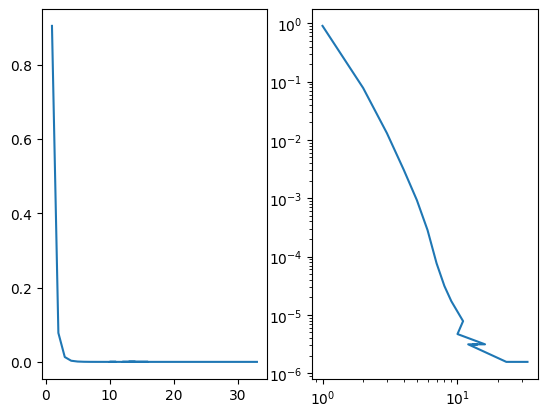

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

it = 'affect'
review_impact_freq = df[df[it] == 1].groupby('review_id').impact_term.value_counts().rename('freq').reset_index()
impact_freq_dist = review_impact_freq.freq.value_counts() / len(review_impact_freq)
impact_freq_dist.plot(ax=ax[0])
impact_freq_dist.plot(ax=ax[1])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
impact_freq_dist.rename('frac').to_frame().reset_index().rename(columns={'index': 'impact_term_freq'}).head(5).style.format(precision=2)

84% of all impact terms occur only once in a review, a further 13% occurs twice and the remaining 3% of terms occur three or four times. This is a strong signal that impact terms are rarely repeated within a review, and that they are to some extent binary elements. That is, what matters is whether they occur or not (the difference between 0 and 1, or _presence_), not how often (_degree_).

## Compute Document Frequencies

The number of times that an impact terms occurs in a review has an extremely skewed distribution, with the vast majority of reviews having an impact term frequency of 0 or 1. We assume that this is because reviewers only once mention a certain type of impact. As a consequence, occurrence of specific impact terms (with their conditional contexts) is close to a binomial distribution. It either occurs or not. Also, if a certain impact term is mentioned twice or more in a review, it is not clear that it expresses more impact than when it is mentioned once. So we could treat impact as a binary. 

In that case, a simple way to compare the occurrence of impact terms across reviews of different genres is to compute the document frequency $DFreq(t, g)$ per genre (that is, the total number of reviews in a genre $g$ in which an impact term $t$ occurs). Because we have different numbers of reviews per genre, we can make them comparable by normalising document frequency $DFreq$ by the number of reviews to get the document fraction $DFrac(t, g)$. 

### Step 1: Computing Document Frequencies

How many impact terms are there per impact type?

In [38]:
impact_types = ['affect', 'aesthetic', 'narrative']

impact_terms = {it: list(df[df[it] == 1].impact_term.unique()) for it in impact_types}

for it in impact_terms:
    print(it, len(impact_terms[it]))

affect 49
aesthetic 56
narrative 85


Next, build an impact term occurrence matrix, with a binary value for whether a term occurs in a review.

In [39]:
impact_doc_freq = {}

for it in impact_types:
    impact_doc_freq[it] = df[df[it] == 1][['review_id', 'nur_genre', 'impact_term']].drop_duplicates()
    impact_doc_freq[it]['impact_type'] = it
    impact_doc_freq[it]['occurs'] = 1
    index_cols = ['impact_type', 'nur_genre', 'review_id']
    impact_doc_freq[it] = (impact_doc_freq[it].pivot(index=index_cols, 
                                                     columns='impact_term', 
                                                     values='occurs')
                           .fillna(0.0))
impact_doc_freq['aesthetic'].head(5)

impact_term                                        (spreekt|spreken|sprak|spraken).+(me).+(aan)  \
impact_type nur_genre        review_id                                                            
aesthetic   Children_fiction impfic-review-100154                                           0.0   
                             impfic-review-100155                                           0.0   
                             impfic-review-100156                                           0.0   
                             impfic-review-100258                                           0.0   
                             impfic-review-100306                                           0.0   

impact_term                                        aangenaam  aantrekkelijk  \
impact_type nur_genre        review_id                                        
aesthetic   Children_fiction impfic-review-100154        0.0            0.0   
                             impfic-review-100155        0.0            0.0   
                             impfic-review-100156        0.0            0.0   
                             impfic-review-100258        0.0            0.0   
                             impfic-review-100306        0.0            0.0   

impact_term                                        apart  beschreven  \
impact_type nur_genre        review_id                                 
aesthetic   Children_fiction impfic-review-100154    0.0         0.0   
                             impfic-review-100155    0.0         0.0   
                             impfic-review-100156    0.0         1.0   
                             impfic-review-100258    0.0         0.0   
                             impfic-review-100306    0.0         0.0   

impact_term                                        beschrijven  bijzonder  \
impact_type nur_genre        review_id                                      
aesthetic   Children_fiction impfic-review-100154          0.0        0.0   
                             impfic-review-100155          0.0        0.0   
                             impfic-review-100156          1.0        0.0   
                             impfic-review-100258          0.0        0.0   
                             impfic-review-100306          0.0        0.0   

impact_term                                        boeien  boeiend  droog  \
impact_type nur_genre        review_id                                      
aesthetic   Children_fiction impfic-review-100154     0.0      0.0    0.0   
                             impfic-review-100155     0.0      0.0    0.0   
                             impfic-review-100156     0.0      0.0    0.0   
                             impfic-review-100258     0.0      0.0    0.0   
                             impfic-review-100306     0.0      0.0    0.0   

impact_term                                        ...  prettig  scherp  \
impact_type nur_genre        review_id             ...                    
aesthetic   Children_fiction impfic-review-100154  ...      0.0     0.0   
                             impfic-review-100155  ...      0.0     0.0   
                             impfic-review-100156  ...      0.0     0.0   
                             impfic-review-100258  ...      0.0     0.0   
                             impfic-review-100306  ...      0.0     0.0   

impact_term                                        schitterend  schrijfstijl  \
impact_type nur_genre        review_id                                         
aesthetic   Children_fiction impfic-review-100154          0.0           1.0   
                             impfic-review-100155          0.0           1.0   
                             impfic-review-100156          0.0           0.0   
                             impfic-review-100258          0.0           0.0   
                             impfic-review-100306          0.0           0.0   

impact_term                                        stijl  subtiel  \
impact_type

Sum of the terms occurrence per review gives the number of reviews that contain an impact term.

In [40]:
genre_impact_doc_freq = {}
for it in impact_types:
    genre_impact_doc_freq[it] = (impact_doc_freq[it]
                                 .reset_index()
                                 .groupby('nur_genre')[impact_terms[it]]
                                 .sum()
                                 .fillna(0.0))

it = 'aesthetic'
genre_impact_doc_freq[it]

impact_term,stijl,goed (geschreven|omschreven|beschreven),beschrijven,beschreven,helder,fantastisch,geweldig,omschrijven,taalgebruik,zinnen,...,apart,aantrekkelijk,gelachen,intens,uniek,intrigeren,(spreekt|spreken|sprak|spraken).+(me).+(aan),opmerkelijk,intrigerend,overtuigend
nur_genre,,,,,,,,,,,,,,,,,,,,,
Children_fiction,302.0,486.0,1097.0,896.0,199.0,71.0,174.0,256.0,460.0,716.0,...,16.0,31.0,131.0,8.0,21.0,5.0,9.0,3.0,1.0,0.0
Fantasy_fiction,306.0,507.0,1101.0,918.0,140.0,72.0,125.0,350.0,260.0,336.0,...,28.0,6.0,26.0,17.0,36.0,31.0,3.0,8.0,5.0,0.0
Historical_fiction,60.0,128.0,395.0,339.0,42.0,9.0,27.0,46.0,63.0,100.0,...,1.0,3.0,3.0,6.0,2.0,7.0,3.0,4.0,0.0,0.0
Literary_fiction,7241.0,5536.0,17498.0,14387.0,2558.0,735.0,1528.0,3323.0,4840.0,9513.0,...,367.0,148.0,1179.0,438.0,346.0,418.0,121.0,178.0,64.0,4.0
Literary_thriller,1802.0,3317.0,5644.0,4755.0,843.0,220.0,547.0,1156.0,1140.0,2013.0,...,116.0,42.0,55.0,83.0,97.0,171.0,28.0,37.0,33.0,0.0
Non-fiction,1123.0,1296.0,5194.0,4452.0,4715.0,142.0,352.0,1170.0,653.0,1036.0,...,51.0,64.0,261.0,38.0,82.0,36.0,28.0,30.0,8.0,1.0
Other fiction,968.0,987.0,2828.0,2252.0,893.0,118.0,268.0,579.0,533.0,1008.0,...,45.0,21.0,240.0,69.0,92.0,49.0,13.0,27.0,11.0,1.0
Regional_fiction,24.0,46.0,108.0,91.0,12.0,5.0,3.0,16.0,27.0,24.0,...,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0
Romance,118.0,185.0,453.0,369.0,24.0,7.0,39.0,164.0,47.0,102.0,...,4.0,4.0,53.0,8.0,15.0,0.0,3.0,1.0,0.0,0.0


In [60]:
it = 'aesthetic'
genre_impact_doc_freq[it]['ontzettend']

nur_genre
Children_fiction       37.0
Fantasy_fiction        49.0
Historical_fiction      9.0
Literary_fiction      320.0
Literary_thriller     145.0
Non-fiction             8.0
Other fiction          42.0
Regional_fiction        1.0
Romance                30.0
Suspense              118.0
Young_adult           148.0
unknown               121.0
Name: ontzettend, dtype: float64

In [63]:
it = 'aesthetic'
genre_impact_doc_frac[it].loc['ontzettend']

Children_fiction      0.004267
Fantasy_fiction       0.004961
Historical_fiction    0.003953
Literary_fiction      0.004285
Literary_thriller     0.003975
Non-fiction           0.002072
Other fiction         0.004980
Regional_fiction      0.000728
Romance               0.005441
Suspense              0.004009
Young_adult           0.007463
unknown               0.003631
Name: ontzettend, dtype: float64

How many reviews contain the impact term _spannend_?

In [41]:
it = 'narrative'
genre_impact_doc_freq[it]['spannend']

nur_genre
Children_fiction       6342.0
Fantasy_fiction        2819.0
Historical_fiction      389.0
Literary_fiction      14081.0
Literary_thriller     27613.0
Non-fiction            2102.0
Other fiction          2091.0
Regional_fiction         93.0
Romance                 480.0
Suspense              23643.0
Young_adult            6918.0
unknown                9302.0
Name: spannend, dtype: float64

### Step 2: Computing Document Fraction

The document fraction $DocFrac(g)$ for a genre $g$ is the document frequency $DocFreq(g)$ divided by the number of reviews $|r_{G=g}|$.

In [42]:
genre_num_reviews = review_stats.nur_genre.value_counts()
genres = list(genre_num_reviews.index)


genre_impact_doc_frac = {}

for it in impact_types:
    genre_impact_doc_frac[it] = genre_impact_doc_freq[it].T.div(genre_num_reviews)

it = 'aesthetic'
genre_impact_doc_frac[it].head(2)

,Children_fiction,Fantasy_fiction,Historical_fiction,Literary_fiction,Literary_thriller,Non-fiction,Other fiction,Regional_fiction,Romance,Suspense,Young_adult,unknown
impact_term,,,,,,,,,,,,
stijl,0.012044,0.023357,0.018243,0.037339,0.023795,0.011811,0.027864,0.017467,0.018883,0.025815,0.014996,0.037160
goed (geschreven|omschreven|beschreven),0.019383,0.038699,0.038918,0.028547,0.043801,0.013630,0.028411,0.033479,0.029605,0.040644,0.036595,0.023905


In [43]:
genre_impact_doc_frac['aesthetic'].loc['schrijfstijl'].sort_values()

Non-fiction           0.020130
Children_fiction      0.055795
unknown               0.059234
Other fiction         0.074640
Literary_fiction      0.088246
Fantasy_fiction       0.104343
Historical_fiction    0.105807
Literary_thriller     0.118634
Suspense              0.120803
Regional_fiction      0.124454
Young_adult           0.134617
Romance               0.144183
Name: schrijfstijl, dtype: float64

In [109]:
genre_impact_doc_freq[it].loc[g1][ratio.idxmax()]
#genre_num_reviews
genre_impact_doc_frac[it].loc[ratio.idxmax()][g2]
it, ratio.idxmax(), g2

('aesthetic', 'literair', 'Non-fiction')

In [115]:
from itertools import combinations

it = 'aesthetic'
genre_impact_doc_frac[it]
max_ratio = []
for g1, g2 in combinations(genres, 2):
    ratio = genre_impact_doc_frac[it][g1] / genre_impact_doc_frac[it][g2]
    ratio = ratio[(ratio != np.inf) & (pd.isna(ratio) == False)]
    #max_ratio[(g1, g2)] = (ratio.max(), genre_impact_doc_freq[it].loc[g1][ratio.idxmax()])
    max_ratio.append([
        g1, g2, 
        ratio.idxmax(), ratio.max(), 
        genre_impact_doc_freq[it].loc[g1][ratio.idxmax()], genre_impact_doc_freq[it].loc[g2][ratio.idxmax()],
        genre_impact_doc_frac[it].loc[ratio.idxmax()][g1], genre_impact_doc_frac[it].loc[ratio.idxmax()][g2]
    ])


g1, g2, ratio.sort_values()
ratio[(ratio < 100) & (ratio > 2)]
ratio.max()
max_ratio = pd.DataFrame(data=max_ratio, columns=['g1', 'g2', 'term', 'ratio', 'freq1', 'freq2', 'frac1', 'frac2'])
max_ratio[max_ratio.term == 'apart']
max_ratio.sort_values('frac1')

,g1,g2,term,ratio,freq1,freq2,frac1,frac2
1,Literary_fiction,unknown,overtuigend,1.868918,4.0,1.0,0.000021,0.000011
57,Children_fiction,Romance,pakkend,2.741445,11.0,1.0,0.000439,0.000160
51,Young_adult,Children_fiction,geniaal,6.036733,14.0,2.0,0.000482,0.000080
41,Suspense,Fantasy_fiction,geniaal,2.698279,41.0,3.0,0.000618,0.000229
25,unknown,Children_fiction,geniaal,11.069343,80.0,2.0,0.000883,0.000080
...,...,...,...,...,...,...,...,...
17,Non-fiction,Fantasy_fiction,helder,4.640447,4715.0,140.0,0.049589,0.010686
19,Non-fiction,Historical_fiction,helder,3.883273,4715.0,42.0,0.049589,0.012770
20,Non-fiction,Regional_fiction,helder,5.677915,4715.0,12.0,0.049589,0.008734
15,Non-fiction,Young_adult,helder,5.399976,4715.0,267.0,0.049589,0.009183


In [118]:
14 / 0.000482, genre_num_reviews

(29045.64315352697,
 Literary_fiction      193924
 Non-fiction            95082
 unknown                90607
 Literary_thriller      75729
 Suspense               66356
 Other fiction          34740
 Young_adult            29075
 Children_fiction       25074
 Fantasy_fiction        13101
 Romance                 6249
 Historical_fiction      3289
 Regional_fiction        1374
 Name: nur_genre, dtype: int64)

## Correlations between Document Fractions

The fractions per genre and per term allow us to compare the genres through Pearson correlation. If the usage of impact terms between two genres has a similar distribution, they have a high Pearson correlation.

In [44]:
import dataframe_image as dfi

from src.plot import GENRE_MAP_LONG as genre_map_long
from src.plot import GENRE_MAP_SHORT as genre_map_short


In [45]:
for it in impact_types:
    print(it)
    table = (genre_impact_doc_frac[it]
             .rename(columns=genre_map_short)
             .corr()
             .style
             .format(precision=3)
             .background_gradient(axis=None))
    
    dfi.export(table, f'../images/doc_prop/doc_prop-pearson_corr-genre-{it}.png', dpi=150)
table

affect
aesthetic
narrative


,Child. fic,Fantasy,Hist. fic,Lit. fic,Lit. thrill,Non-fic,Oth. fic,Reg. fic,Romance,Suspense,YA,Unkn.
Child. fic,1.000,0.943,0.829,0.774,0.933,0.498,0.685,0.693,0.583,0.929,0.954,0.934
Fantasy,0.943,1.000,0.886,0.805,0.970,0.415,0.661,0.722,0.657,0.970,0.979,0.953
Hist. fic,0.829,0.886,1.000,0.908,0.892,0.470,0.777,0.855,0.748,0.896,0.914,0.924
Lit. fic,0.774,0.805,0.908,1.000,0.803,0.712,0.936,0.888,0.712,0.802,0.852,0.921
Lit. thrill,0.933,0.970,0.892,0.803,1.000,0.397,0.644,0.691,0.604,0.999,0.969,0.958
Non-fic,0.498,0.415,0.470,0.712,0.397,1.000,0.885,0.669,0.476,0.391,0.485,0.595
Oth. fic,0.685,0.661,0.777,0.936,0.644,0.885,1.000,0.868,0.681,0.644,0.729,0.814
Reg. fic,0.693,0.722,0.855,0.888,0.691,0.669,0.868,1.000,0.860,0.692,0.774,0.798
Romance,0.583,0.657,0.748,0.712,0.604,0.476,0.681,0.860,1.000,0.614,0.696,0.686
Suspense,0.929,0.970,0.896,0.802,0.999,0.391,0.644,0.692,0.614,1.000,0.972,0.957


## Zeta Scores

In [38]:
from itertools import permutations

genre_impact_doc_frac['aesthetic'].loc['schrijfstijl'].to_frame().T
# s = genre_impact_doc_frac['stylistic'].loc['schrijfstijl']

zeta_scores = {
    'impact_type': [],
    'genre1': [],
    'genre2': [],
    'zeta_sum': [],
    'zeta_mean': []
}

fiction_genres = [genre for genre in genres if genre not in {'Non-fiction', 'unknown'}]

for impact_type in impact_types:
    for g1, g2 in permutations(fiction_genres, 2):
        zeta = abs(genre_impact_doc_frac[impact_type][g1] - genre_impact_doc_frac[impact_type][g2])
        #zeta = genre_impact_doc_frac[impact_type][g1] - genre_impact_doc_frac[impact_type][g2]
        zeta_scores['impact_type'].append(impact_type)
        zeta_scores['genre1'].append(g1)
        zeta_scores['genre2'].append(g2)
        zeta_scores['zeta_sum'].append(zeta.sum())
        zeta_scores['zeta_mean'].append(zeta.mean())
    

zeta_df = pd.DataFrame(zeta_scores)
zeta_df = zeta_df.pivot(index=['impact_type', 'genre1'], values=['zeta_sum'], columns=['genre2']).fillna(0.0)


In [39]:
zeta

impact_term
fantastisch                            0.001750
spanning                               0.029036
levendig                               0.003419
verrassen                              0.004204
gelukkig                               0.002605
                                         ...   
(zien|ziet|zag).+(voor (me|mij|je))    0.002617
geboeid                                0.000728
verrast                                0.000000
meegezogen                             0.000000
gegrepen                               0.000000
Length: 85, dtype: float64

In [40]:
zeta_df

zeta_sum                  \
genre2                         Children_fiction Fantasy_fiction   
impact_type genre1                                                
aesthetic   Children_fiction           0.000000        0.319622   
            Fantasy_fiction            0.319622        0.000000   
            Historical_fiction         0.578353        0.463010   
            Literary_fiction           0.331832        0.315857   
            Literary_thriller          0.463460        0.242883   
            Other fiction              0.259915        0.276306   
            Regional_fiction           0.408584        0.330471   
            Romance                    0.437015        0.387406   
            Suspense                   0.456259        0.234566   
            Young_adult                0.289654        0.189654   
affective   Children_fiction           0.000000        0.705977   
            Fantasy_fiction            0.705977        0.000000   
            Historical_fiction         0.829361        0.470351   
            Literary_fiction           0.700824        0.449784   
            Literary_thriller          0.859523        0.398531   
            Other fiction              0.602549        0.405350   
            Regional_fiction           0.871671        0.515105   
            Romance                    0.599420        0.593762   
            Suspense                   0.833184        0.369541   
            Young_adult                0.637034        0.321595   
narrative   Children_fiction           0.000000        0.494323   
            Fantasy_fiction            0.494323        0.000000   
            Historical_fiction         0.686709        0.622435   
            Literary_fiction           0.627294        0.695145   
            Literary_thriller          0.756042        0.620514   
            Other fiction              0.609451        0.791561   
            Regional_fiction           0.651134        0.746675   
            Romance                    0.727133        0.726776   
            Suspense                   0.745790        0.585867   
            Young_adult                0.537008        0.374183   

                                                                    \
genre2                         Historical_fiction Literary_fiction   
impact_type genre1                                                   
aesthetic   Children_fiction             0.578353         0.331832   
            Fantasy_fiction              0.463010         0.315857   
            Historical_fiction           0.000000         0.407932   
            Literary_fiction             0.407932         0.000000   
            Literary_thriller            0.519557         0.460573   
            Other fiction                0.476261         0.178101   
            Regional_fiction             0.318746         0.373838   
            Romance                      0.695812         0.508467   
            Suspense                     0.543649         0.470196   
            Young_adult                  0.438096         0.315808   
affective   Children_fiction             0.829361         0.700824   
            Fantasy_fiction              0.470351         0.449784   
            Historical_fiction           0.000000         0.265013   
            Literary_fiction             0.265013         0.000000   
            Literary_thriller            0.372942         0.372235   
            Other fiction                0.327831         0.195261   
            Regional_fiction             0.309281         0.383217   
            Romance                      0.611847         0.597331   
            Suspense                     0.354296         0.351240   
            Young_adult                  0.559467         0.529586   
narrative   Children_fiction             0.686709         0.627294   
            Fantasy_fiction              0.622435         0.695145   
            Historical_fiction           0.000000         0.380557   
       

In [42]:
(zeta_df.loc['affective']
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style.format(precision=3).background_gradient(axis=None))


In [43]:
(zeta_df.loc['narrative']
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style.format(precision=2).background_gradient(axis=None))


In [44]:
(zeta_df.loc['aesthetic']
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style.format(precision=2).background_gradient(axis=None))


In [45]:
g1 = 'Historical_fiction'
g2 = 'Romance'
impact_type = 'aesthetic'
(genre_impact_doc_frac[impact_type][g1] - genre_impact_doc_frac[impact_type][g2]).sort_values().head(5)
#sns.scatterplot(x=genre_impact_doc_frac[impact_type][g1], y=genre_impact_doc_frac[impact_type][g2], )

impact_term
humor          -0.093295
luchtig        -0.048360
schrijfstijl   -0.040664
hilarisch      -0.016947
humoristisch   -0.016003
dtype: float64

In [48]:
genres

['Literary_fiction',
 'Non-fiction',
 'unknown',
 'Literary_thriller',
 'Suspense',
 'Other fiction',
 'Young_adult',
 'Children_fiction',
 'Fantasy_fiction',
 'Romance',
 'Historical_fiction',
 'Regional_fiction']

In [46]:
temp_df = genre_impact_doc_frac[impact_type]
sign_diff = (temp_df[g1] - temp_df[g2])
abs_diff = abs(temp_df[g1] - temp_df[g2])
diff = (pd.concat([temp_df[g1], temp_df[g2], sign_diff, abs_diff], axis=1)
        .rename(columns={0: 'sign_diff', 1: 'abs_diff'})
        .sort_values('sign_diff'))

diff.head(5)

,Historical_fiction,Romance,sign_diff,abs_diff
impact_term,,,,
humor,0.018243,0.111538,-0.093295,0.093295
luchtig,0.009729,0.058089,-0.048360,0.048360
schrijfstijl,0.106719,0.147384,-0.040664,0.040664
hilarisch,0.002736,0.019683,-0.016947,0.016947
humoristisch,0.003040,0.019043,-0.016003,0.016003


In [46]:
from src.plot import plot_genre_frac_diff

In [48]:
#genre_impact_doc_frac

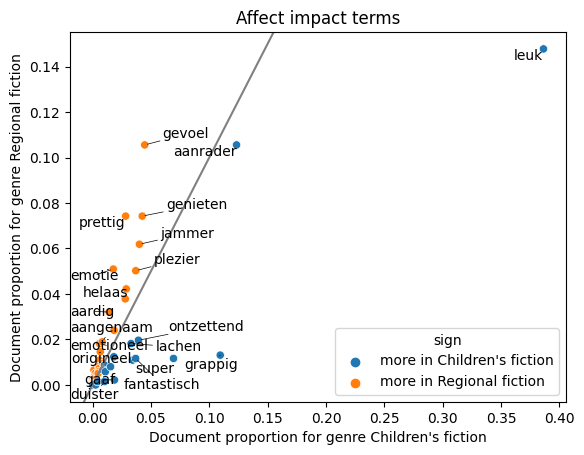

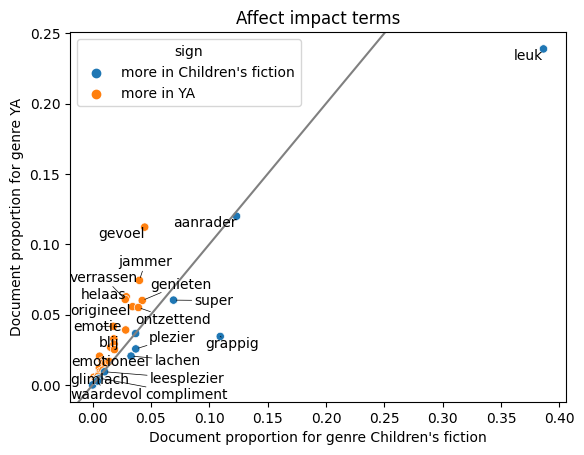

In [49]:
impact_type = 'affect'
genre1 = 'Children_fiction'
genre2 = 'Regional_fiction'
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)

impact_type = 'affect'
genre1 = 'Children_fiction'
genre2 = 'Young_adult'
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)


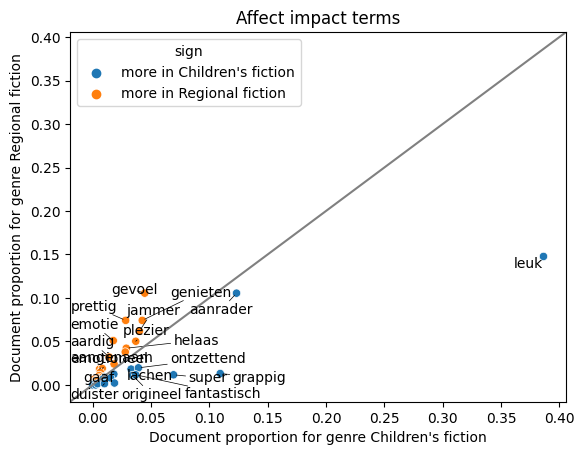

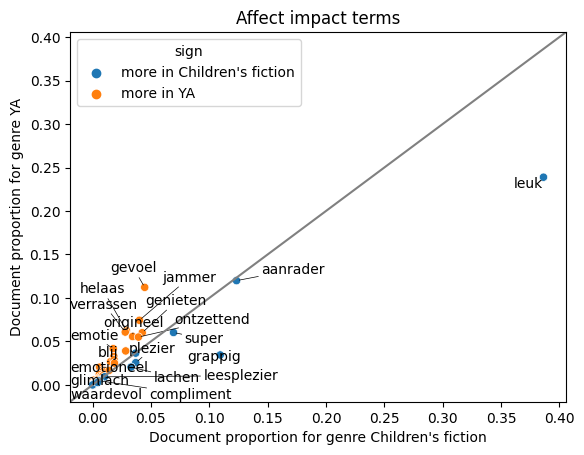

In [51]:
impact_type = 'affect'
genre1 = 'Children_fiction'
genre2 = 'Regional_fiction'
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2, match_scales=True)

impact_type = 'affect'
genre1 = 'Children_fiction'
genre2 = 'Young_adult'
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2, match_scales=True)


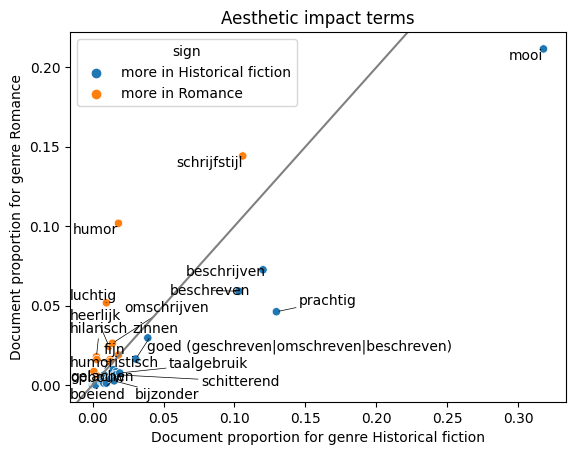

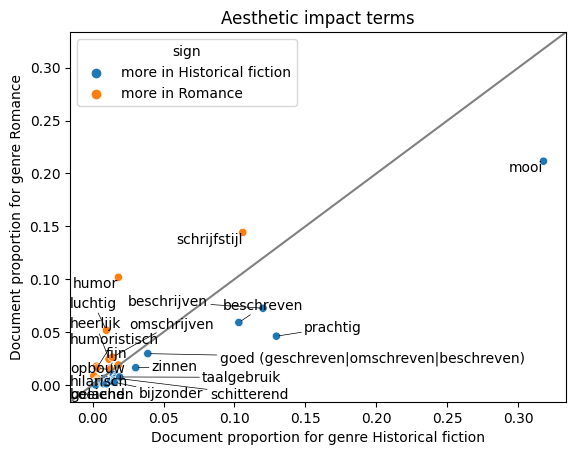

In [52]:
genre1 = 'Historical_fiction'
genre2 = 'Romance'
impact_type = 'aesthetic'

plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2, match_scales=True)


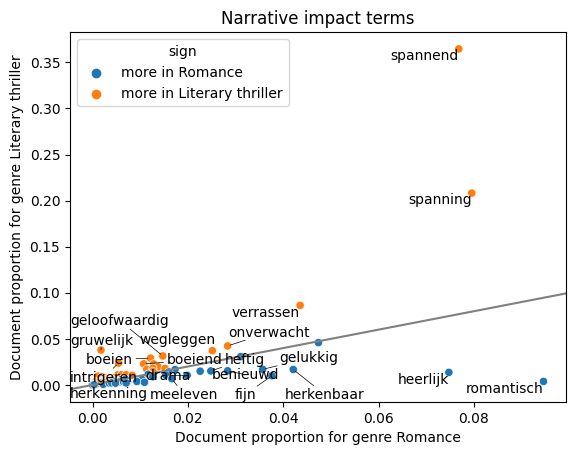

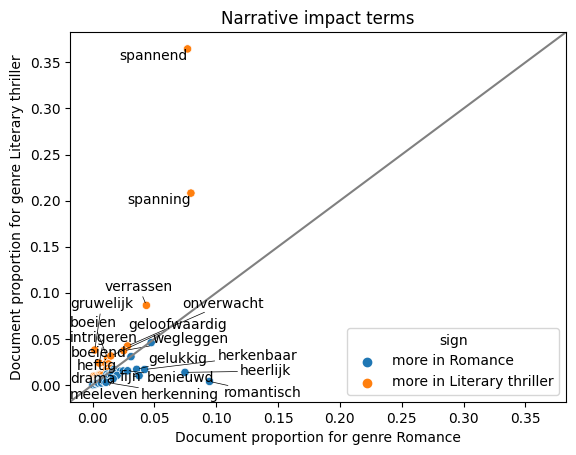

In [53]:
impact_type = 'narrative'
genre1 = 'Romance'
genre2 = 'Literary_thriller'
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)
plot_genre_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2, match_scales=True)
